# Разведочный анализ данных

In [69]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pymorphy2
import re
import seaborn as sns

from ast import literal_eval
from collections import Counter
from elasticsearch import Elasticsearch
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
from wordcloud import WordCloud

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ephobia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
INDEX_NAME = "vacancies"
ES = Elasticsearch(hosts="http://localhost:9200")

Выберем из данных общие нетехнические категориальные и вещественные поля, отдельно - текстуальные для дальнейшего анализа.

In [5]:
categorical_fields = [
    "id",
    "key_skills.name",
    "schedule.name",
    "accept_handicapped",
    "accept_kids",
    "experience.name",
    "address.city",
    "employment.name",
    "salary.currency",
    "professional_roles.name"
    "languages.name",
]

In [6]:
text_fields = [
    "postpoc_desc",
    "postpoc_branded_desc"
]

In [7]:
other_fields = [
    "salary.to_final", 
    "salary.from_final",
    "max_final_salary",
    "max_salary",
    "name",
    "employer.name"
]

Получим данные из базы и минимально обработаем для загрузки в датафрейм.

In [8]:
response = ES.search(
    index=INDEX_NAME, 
    query={
        "match_all": {}
    }, size = 30000, 
    _source=["id"] + categorical_fields + other_fields + text_fields
    )

documents = response["hits"]["hits"]

In [9]:
def flatten_response(document):
    source = document["_source"]
    for key in source:
        if isinstance(source[key], list):
            values = [el["name"] for el in source[key]]
            source[key] = values
    return source

In [10]:
documents = [flatten_response(d) for d in documents]

In [11]:
documents[0]

{'accept_handicapped': False,
 'employment': {'name': 'Полная занятость'},
 'salary': {'from_final': 80000.0, 'currency': 'RUR'},
 'experience': {'name': 'Нет опыта'},
 'postpoc_branded_desc': '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n1 000\n                                    мебельных салонов\n                                \n\n\n\n\n10 000\n                                    талантливых сотрудников\n                                \n\n\n\n\n500\n                                    городов\n                                \n\n\n\n\n\n\nМебельная компания №1 в\xa0России \n                                 по данным исследования мебельного рынка компаний РБК\n                             \n\n\n\n\n\n\n\n\n\nМебельная компания №1 в России в связи с активным развитием производит набор Продавцов в салоны мебели. Мы даем: 1. Стабильно высокий доход - з/п успешного продавца свыше 100 т.р. 2. Стремительный карьерный рост - за год можешь стать директором филиала. 3. Ежемесячные и годовые бо

## Общий анализ основных полей

In [12]:
df = pd.json_normalize(documents)

In [13]:
df.head()

,accept_handicapped,postpoc_branded_desc,accept_kids,max_final_salary,max_salary,name,id,postpoc_desc,employment.name,salary.from_final,salary.currency,experience.name,schedule.name,employer.name,key_skills,address.city,salary.to_final
0,False,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n1 00...,False,NaN,NaN,Продавец-эксперт,74106345,Мебельная компания №1 в России в связи с актив...,Полная занятость,80000.0,RUR,Нет опыта,Сменный график,Много Мебели,NaN,NaN,NaN
1,False,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nМенеджер п...,False,NaN,-1.0,Менеджер по продажам в банке (м. Солнцево),74093467,Менеджер по продажам в банк: Райффайзенбанк — ...,Полная занятость,NaN,NaN,От 1 года до 3 лет,Полный день,Райффайзен Банк,"[Ориентация на результат, Работа в команде, Ак...",Москва,NaN
2,False,None,False,20000.0,20000.0,Менеджер wildberries,74060491,Обязанности: Ведение аналитики личного кабине...,Полная занятость,20000.0,RUR,От 1 года до 3 лет,Гибкий график,Харитонов Антон Алексеевич,"[Амбициозность, Желание обучаться, Умение рабо...",NaN,20000.0
3,False,None,False,34800.0,40000.0,Электромонтер по ремонту и обслуживанию электр...,74083801,Обязанности: Обслуживать силовые и осветитель...,Полная занятость,NaN,RUR,От 1 года до 3 лет,Полный день,ДОДХИБИМР,"[Пользователь ПК, Деловое общение, оформление ...",село Лучинское,34800.0
4,False,None,False,50000.0,50000.0,Мастер по организации эксплуатации и ремонту з...,74079460,Обязанности: Обеспечение обслуживания и содер...,Полная занятость,50000.0,RUR,От 1 года до 3 лет,Полный день,АУ УР СК Чекерил,"[Пользователь ПК, Ремонтные работы, Организаци...",Ижевск,50000.0


In [14]:
df.to_csv("vacancies.csv")

Самый интересный момент из общего анализа содержимого полей - тот факт, что большинство вакансий не содержит зарплатной вилки. Поскольку данные о зарплате являются целевыми переменными, мы не будем заполнять пропуски. Для анализа этого параметра ы дальнейшем исключим из выборки данные без указания зарплаты.

Уникальных названий вакансий очень много - каждое второе название уникальное.

In [15]:
df.describe(include="all")

,accept_handicapped,postpoc_branded_desc,accept_kids,max_final_salary,max_salary,name,id,postpoc_desc,employment.name,salary.from_final,salary.currency,experience.name,schedule.name,employer.name,key_skills,address.city,salary.to_final
count,29522,5484,29522,1.383400e+04,2.022200e+04,29522,29522,29522,29522,2.110100e+04,23134,29522,29522,29522,22684,15652,1.339800e+04
unique,2,3934,2,NaN,NaN,15014,29522,22805,5,NaN,9,4,5,12130,16255,1362,NaN
top,False,"\n\n\n\n\n\nУдалённая работа, которая легко вс...",False,NaN,NaN,Продавец-консультант,74081673,Условия: ГАУЗ «Камский детский медицинский ц...,Полная занятость,NaN,RUR,От 1 года до 3 лет,Полный день,Департамент Ф53,"[Пользователь ПК, Медицинская документация, Ра...",Москва,NaN
freq,28454,97,29339,NaN,NaN,241,1,117,26815,NaN,21285,12671,20315,726,226,2907,NaN
mean,NaN,NaN,NaN,7.606122e+04,8.962839e+04,NaN,NaN,NaN,NaN,7.701949e+04,NaN,NaN,NaN,NaN,NaN,NaN,7.644127e+04
std,NaN,NaN,NaN,8.652250e+04,5.355855e+05,NaN,NaN,NaN,NaN,7.798734e+04,NaN,NaN,NaN,NaN,NaN,NaN,6.965725e+04
min,NaN,NaN,NaN,1.200000e+02,-1.000000e+00,NaN,NaN,NaN,NaN,1.200000e+02,NaN,NaN,NaN,NaN,NaN,NaN,1.200000e+02
25%,NaN,NaN,NaN,3.841350e+04,-1.000000e+00,NaN,NaN,NaN,NaN,3.928311e+04,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+04
50%,NaN,NaN,NaN,6.000000e+04,4.200000e+04,NaN,NaN,NaN,NaN,6.000000e+04,NaN,NaN,NaN,NaN,NaN,NaN,6.000000e+04
75%,NaN,NaN,NaN,9.657000e+04,8.500000e+04,NaN,NaN,NaN,NaN,1.000000e+05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+05


Можно увидеть, что большинство наиболее повторяющихся названий вакансий не требуют высокой квалификации. Однако в целом названия очень разнообразны (можно увидеть, что самое популярное значение имеет всего 140 вхождений на выборку), что затрудняет анализ этого поля.

In [16]:
non_null_values = {
    "key_skills": "не указано",
    "address.city": "не указано"
}
df = df.fillna(value=non_null_values)

<BarContainer object of 10 artists>

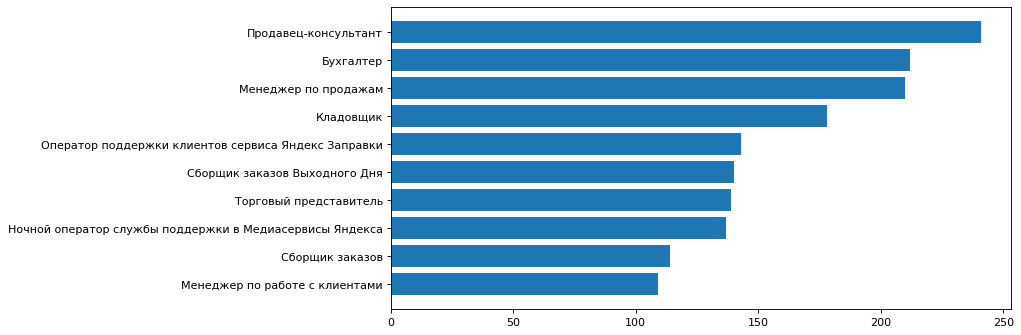

In [17]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(df.name.values).most_common(10)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

<BarContainer object of 10 artists>

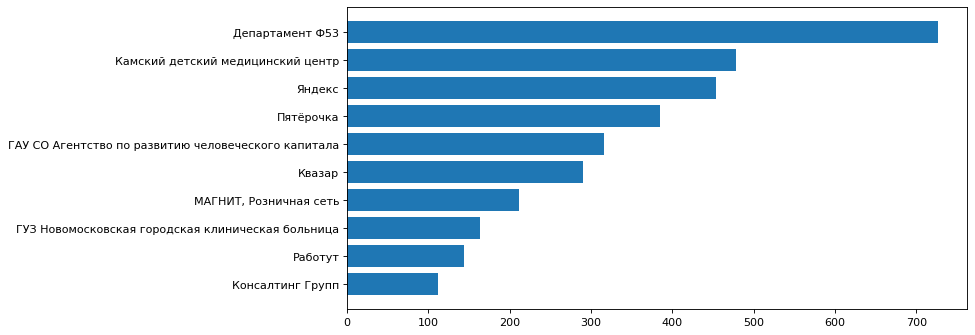

In [18]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(df["employer.name"].values).most_common(10)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

In [19]:
df_sk = df.explode('key_skills')

Самый популярные навыки также достаточно общие, которые можно отнести к широкому спектру специализаций.

<BarContainer object of 10 artists>

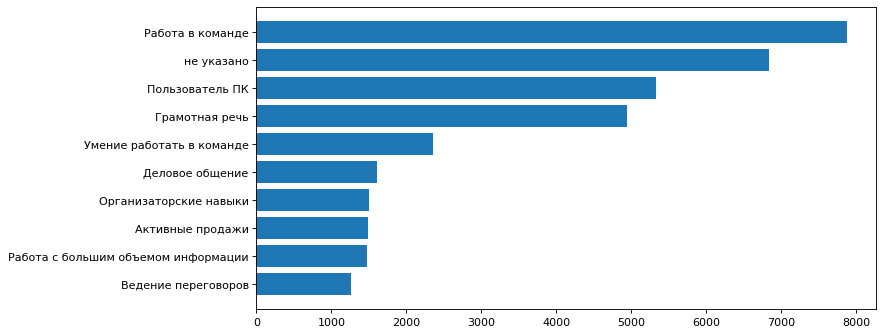

In [20]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(df_sk[df_sk.key_skills.notnull()].key_skills.values).most_common(10)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

<AxesSubplot:>

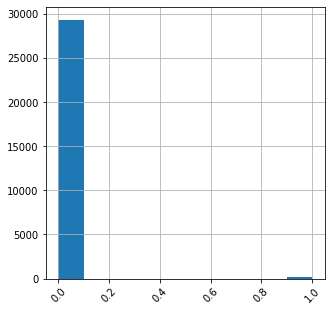

In [21]:
df.accept_kids.astype(int).hist(xrot=45, figsize=(5, 5))

<AxesSubplot:>

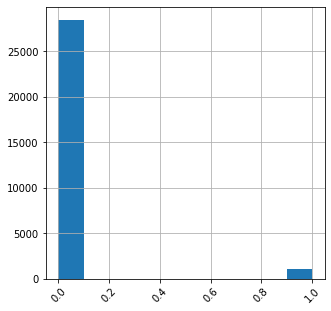

In [22]:
df.accept_handicapped.astype(int).hist(xrot=45, figsize=(5, 5))

<AxesSubplot:>

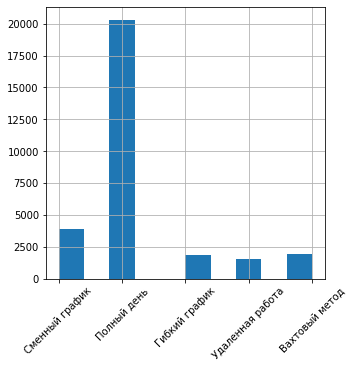

In [23]:
df["schedule.name"].hist(xrot=45, figsize=(5, 5))

<AxesSubplot:>

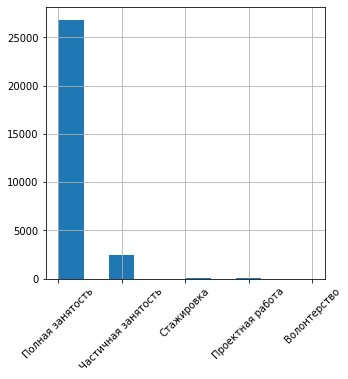

In [24]:
df["employment.name"].hist(xrot=45, figsize=(5, 5))

<AxesSubplot:>

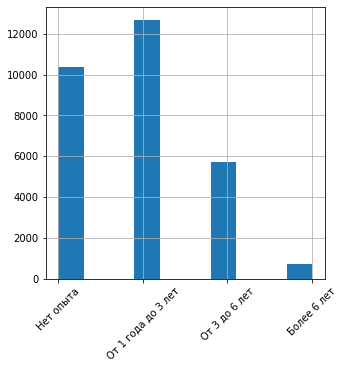

In [25]:
df["experience.name"].hist(xrot=45, figsize=(5, 5))

<BarContainer object of 4 artists>

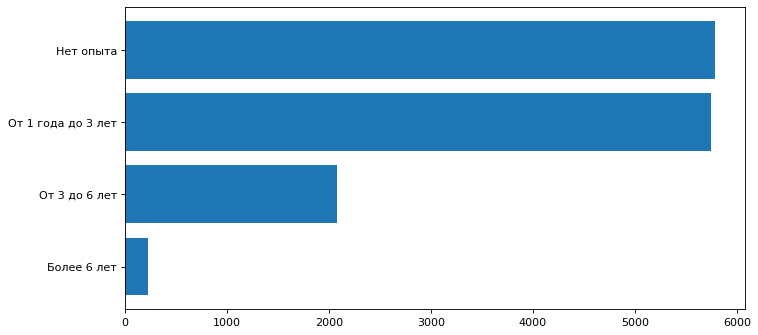

In [33]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(salary_df["experience.name"].values).most_common(10)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

<BarContainer object of 10 artists>

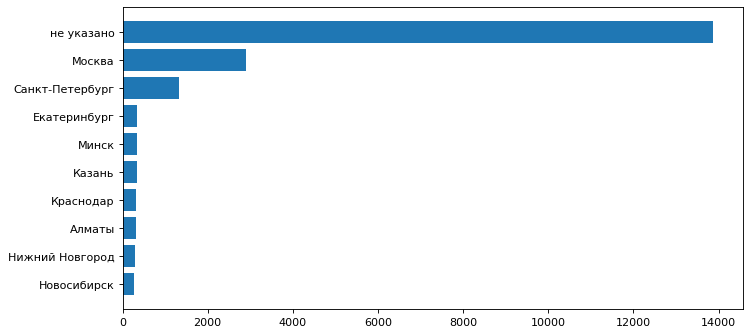

In [100]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(df["address.city"].values).most_common(10)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

## Анализ целевой переменной

In [26]:
salary_df = df[df.max_final_salary.notnull()]

In [96]:
salary_df.size

235178

In [27]:
salary_df_sk = df_sk[df_sk.max_final_salary.notnull()]

In [28]:
np.mean(salary_df.max_final_salary.astype(int))

76061.13994506288

In [29]:
np.max(salary_df.max_final_salary.astype(int))

4350000

In [30]:
np.min(salary_df.max_final_salary.astype(int))

120

Большинство вакансий с указанной зарплатой - до 50 тысяч рублей на руки, хвост очень длинный. Целевую переменную нужно прологарифмировать для формирования таргета, видимо, стоит прологарифмировать.

<AxesSubplot:>

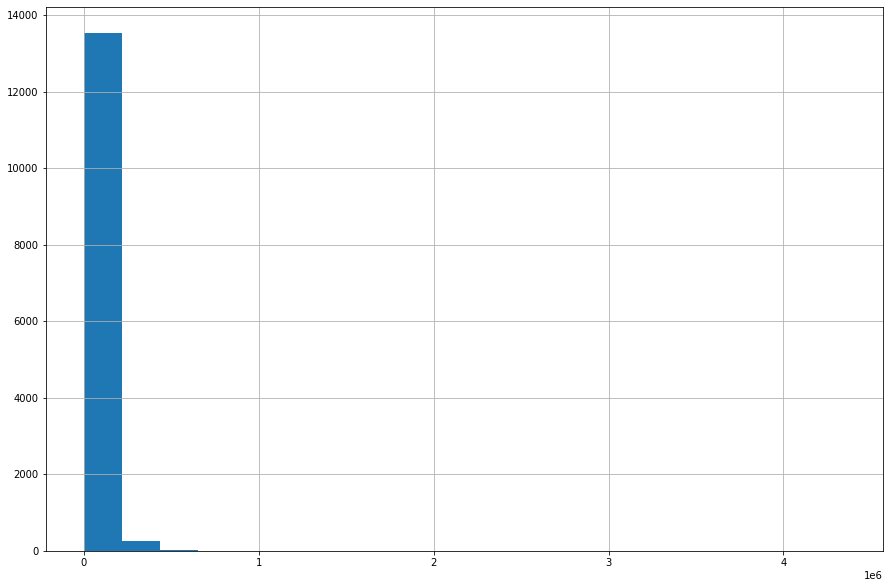

In [31]:
salary_df.max_final_salary.astype(int).hist(figsize=(15, 10), bins=20)

Очень маленькие зарплаты также создают хвост - зарплат, ниже 10 тысяч, тоже довольно мало.

<AxesSubplot:>

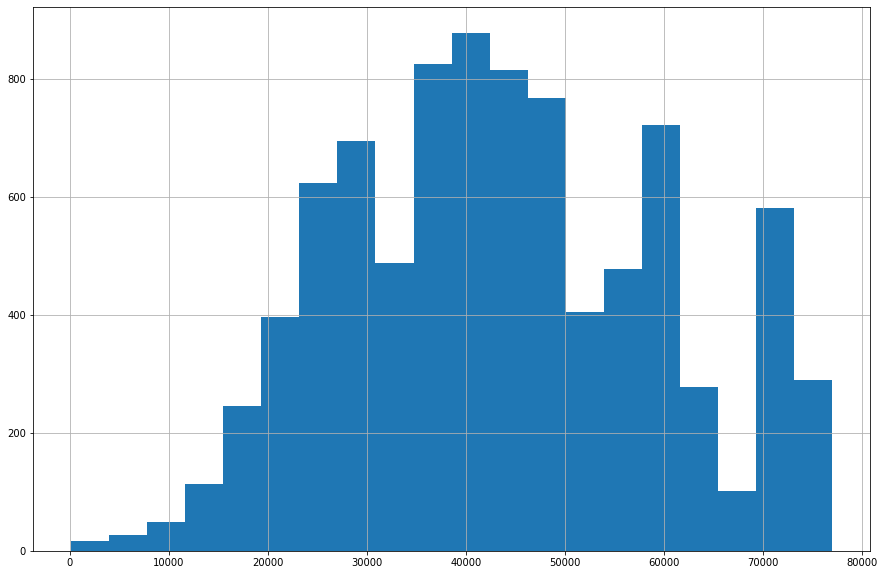

In [32]:
salary_df[salary_df.max_final_salary <= 77000].max_final_salary.astype(int).hist(figsize=(15, 10), bins=20)

Посмотрим, какие работодатели в среднем предлагают наибольшую и наименьшую зарплату.

In [101]:
employer_df = salary_df[["employer.name", "max_final_salary"]].groupby("employer.name").max()

In [102]:
min_employer_salaries = employer_df.sort_values(by="max_final_salary")[:10]
max_employer_salaries = employer_df.sort_values(by="max_final_salary", ascending=False)[:10]

<BarContainer object of 10 artists>

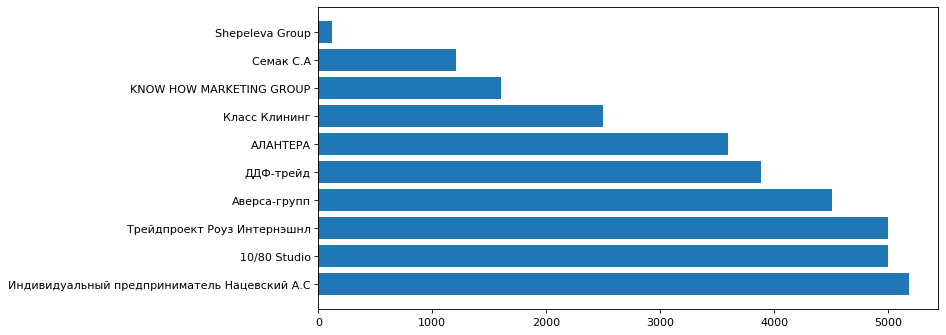

In [103]:
plt.figure(figsize=(10, 5), dpi=80)

keys = min_employer_salaries.index
values = min_employer_salaries.max_final_salary

plt.barh(keys[::-1], values[::-1])

<BarContainer object of 10 artists>

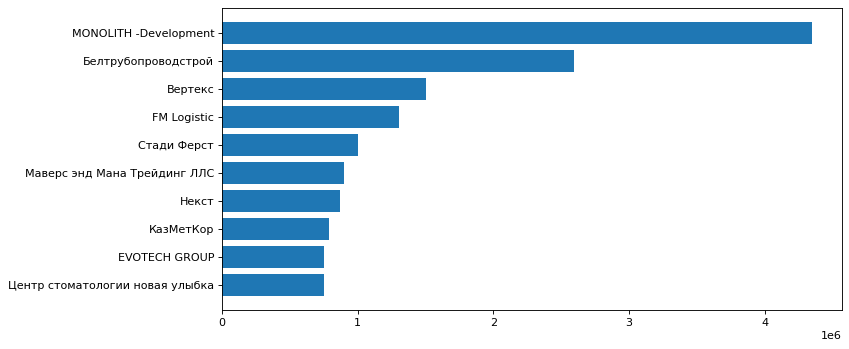

In [104]:
plt.figure(figsize=(10, 5), dpi=80)

keys = max_employer_salaries.index
values = max_employer_salaries.max_final_salary

plt.barh(keys[::-1], values[::-1])

In [38]:
df_skills_grouped = salary_df_sk[["key_skills", "max_final_salary"]].groupby("key_skills").mean()

In [39]:
min_salaries = df_skills_grouped.sort_values(by="max_final_salary")[:10]
max_salaries = df_skills_grouped.sort_values(by="max_final_salary", ascending=False)[:10]

<BarContainer object of 10 artists>

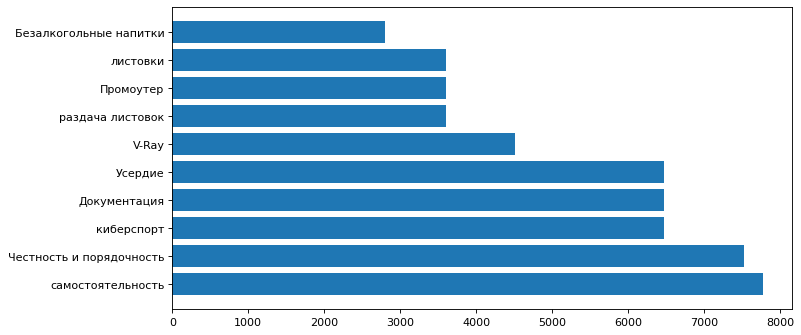

In [40]:
plt.figure(figsize=(10, 5), dpi=80)

keys = min_salaries.index
values = min_salaries.max_final_salary

plt.barh(keys[::-1], values[::-1])

<BarContainer object of 10 artists>

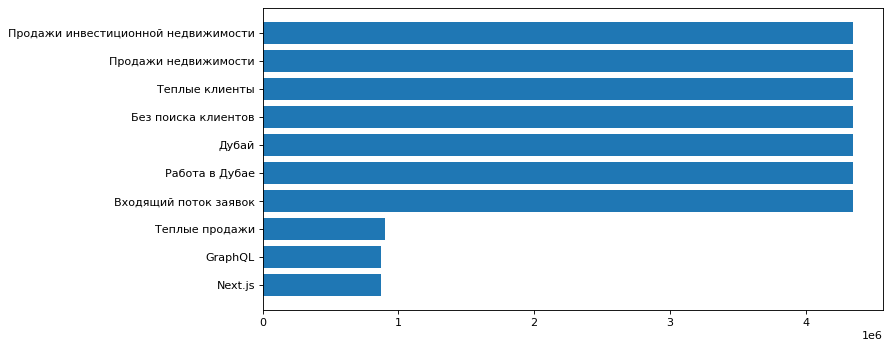

In [41]:
plt.figure(figsize=(10, 5), dpi=80)

keys = max_salaries.index
values = max_salaries.max_final_salary

plt.barh(keys[::-1], values[::-1])

In [42]:
city_df = salary_df[["address.city", "max_final_salary"]].groupby("address.city").mean()

In [43]:
min_city_salaries = city_df.sort_values(by="max_final_salary")[:10]
max_city_salaries = city_df.sort_values(by="max_final_salary", ascending=False)[:10]

<BarContainer object of 10 artists>

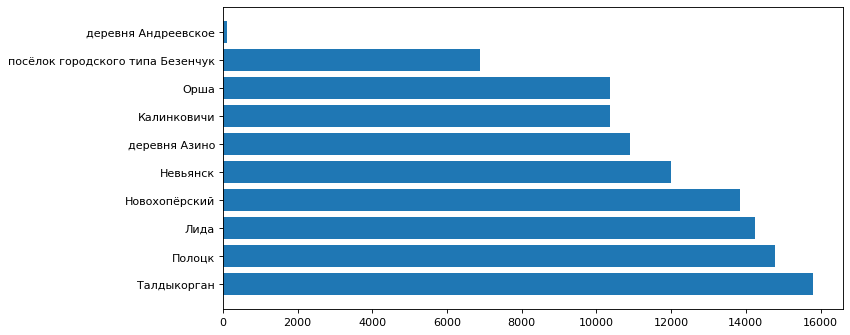

In [44]:
plt.figure(figsize=(10, 5), dpi=80)

keys = min_city_salaries.index
values = min_city_salaries.max_final_salary

plt.barh(keys[::-1], values[::-1])

<BarContainer object of 10 artists>

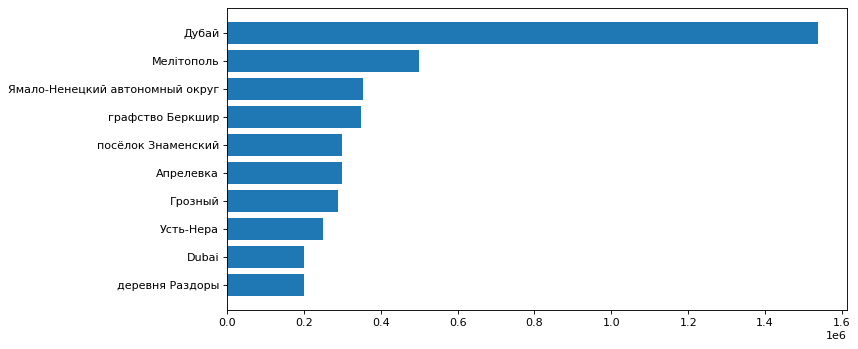

In [45]:
plt.figure(figsize=(10, 5), dpi=80)

keys = max_city_salaries.index
values = max_city_salaries.max_final_salary

plt.barh(keys[::-1], values[::-1])

In [46]:
city_df_max = salary_df[["address.city", "max_final_salary"]].groupby("address.city").max()

In [47]:
min_city_max_salaries = city_df_max.sort_values(by="max_final_salary")[:10]
max_city_max_salaries = city_df_max.sort_values(by="max_final_salary", ascending=False)[:10]

<BarContainer object of 10 artists>

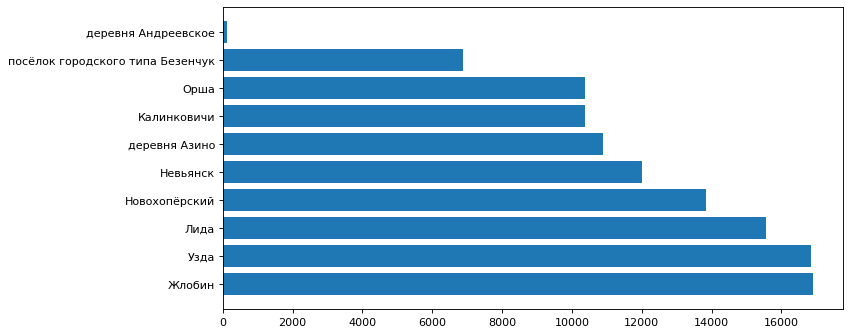

In [48]:
plt.figure(figsize=(10, 5), dpi=80)

keys = min_city_max_salaries.index
values = min_city_max_salaries.max_final_salary

plt.barh(keys[::-1], values[::-1])

<BarContainer object of 10 artists>

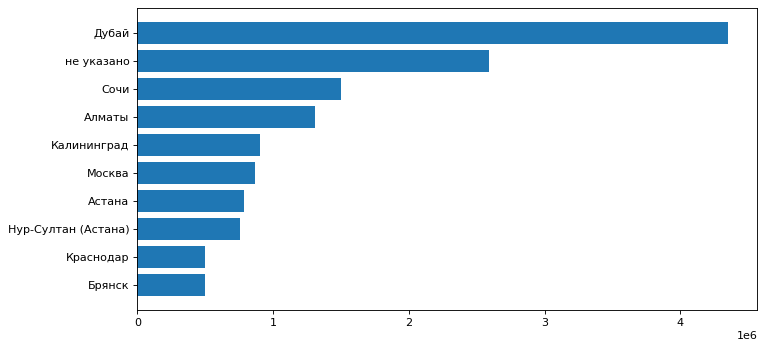

In [49]:
plt.figure(figsize=(10, 5), dpi=80)

keys = max_city_max_salaries.index
values = max_city_max_salaries.max_final_salary

plt.barh(keys[::-1], values[::-1])

In [50]:
experience_df = salary_df[["experience.name", "max_final_salary"]].groupby("experience.name").mean()

<BarContainer object of 4 artists>

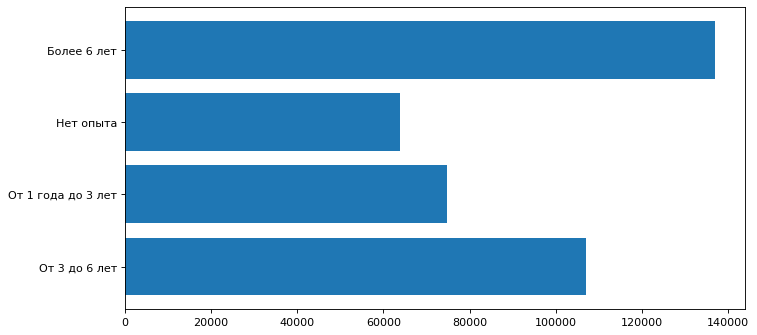

In [51]:
plt.figure(figsize=(10, 5), dpi=80)

keys = experience_df.index
values = experience_df.max_final_salary

plt.barh(keys[::-1], values[::-1])

Посмотрим, для каких вакансий в основном не указаны зарплаты.

In [52]:
no_salary_df = df[df.max_final_salary.isnull()].fillna(value=non_null_values)

In [53]:
no_salary_df_sk = df_sk[df_sk.max_final_salary.isnull()].fillna(value=non_null_values)

<BarContainer object of 10 artists>

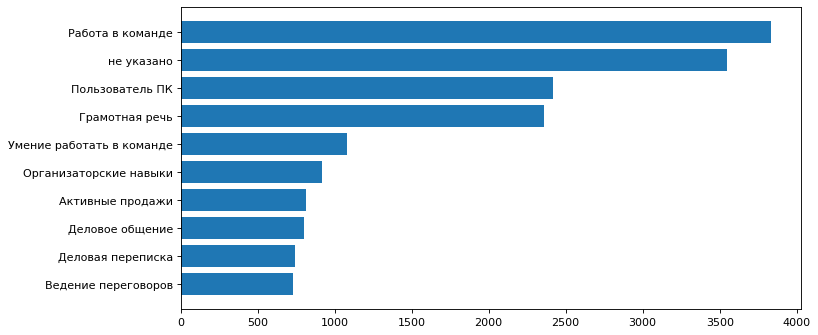

In [54]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(no_salary_df_sk.key_skills.values).most_common(10)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

<BarContainer object of 10 artists>

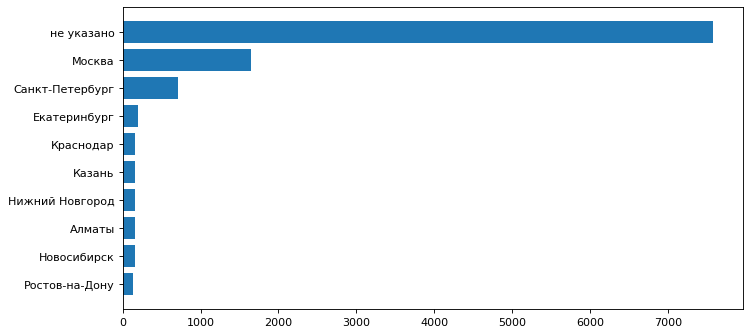

In [55]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(no_salary_df["address.city"].values).most_common(10)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

<BarContainer object of 10 artists>

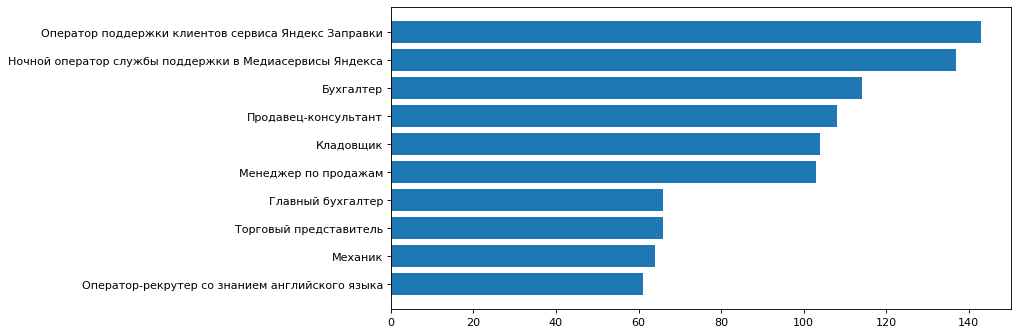

In [56]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(no_salary_df["name"].values).most_common(10)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

<BarContainer object of 10 artists>

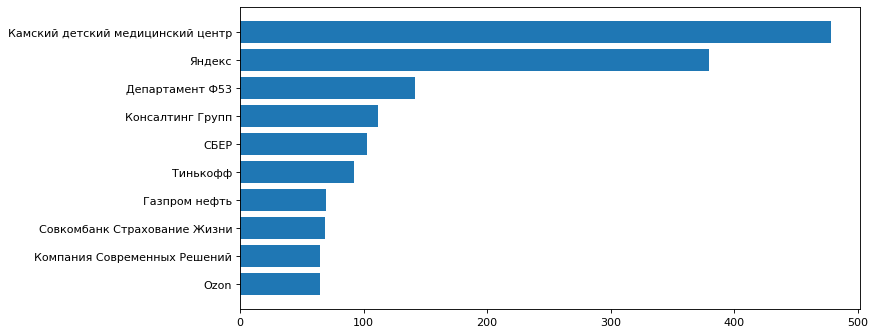

In [57]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(no_salary_df["employer.name"].values).most_common(10)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

<BarContainer object of 4 artists>

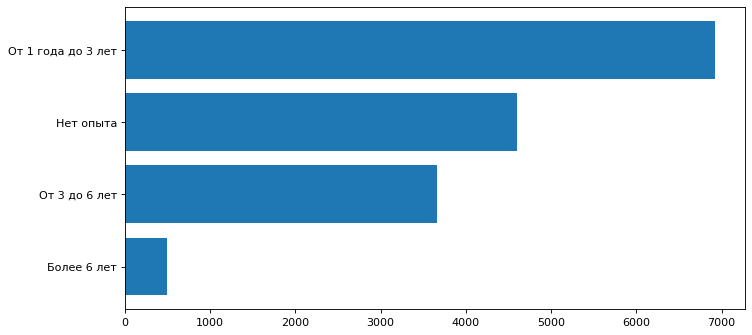

In [58]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(no_salary_df["experience.name"].values).most_common(10)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

## Анализ текстовых данных

In [59]:
text_df = df

In [60]:
text_df.head()

,accept_handicapped,postpoc_branded_desc,accept_kids,max_final_salary,max_salary,name,id,postpoc_desc,employment.name,salary.from_final,salary.currency,experience.name,schedule.name,employer.name,key_skills,address.city,salary.to_final
0,False,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n1 00...,False,NaN,NaN,Продавец-эксперт,74106345,Мебельная компания №1 в России в связи с актив...,Полная занятость,80000.0,RUR,Нет опыта,Сменный график,Много Мебели,не указано,не указано,NaN
1,False,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nМенеджер п...,False,NaN,-1.0,Менеджер по продажам в банке (м. Солнцево),74093467,Менеджер по продажам в банк: Райффайзенбанк — ...,Полная занятость,NaN,NaN,От 1 года до 3 лет,Полный день,Райффайзен Банк,"[Ориентация на результат, Работа в команде, Ак...",Москва,NaN
2,False,None,False,20000.0,20000.0,Менеджер wildberries,74060491,Обязанности: Ведение аналитики личного кабине...,Полная занятость,20000.0,RUR,От 1 года до 3 лет,Гибкий график,Харитонов Антон Алексеевич,"[Амбициозность, Желание обучаться, Умение рабо...",не указано,20000.0
3,False,None,False,34800.0,40000.0,Электромонтер по ремонту и обслуживанию электр...,74083801,Обязанности: Обслуживать силовые и осветитель...,Полная занятость,NaN,RUR,От 1 года до 3 лет,Полный день,ДОДХИБИМР,"[Пользователь ПК, Деловое общение, оформление ...",село Лучинское,34800.0
4,False,None,False,50000.0,50000.0,Мастер по организации эксплуатации и ремонту з...,74079460,Обязанности: Обеспечение обслуживания и содер...,Полная занятость,50000.0,RUR,От 1 года до 3 лет,Полный день,АУ УР СК Чекерил,"[Пользователь ПК, Ремонтные работы, Организаци...",Ижевск,50000.0


In [61]:
text_df.describe()

,max_final_salary,max_salary,salary.from_final,salary.to_final
count,1.383400e+04,2.022200e+04,2.110100e+04,1.339800e+04
mean,7.606122e+04,8.962839e+04,7.701949e+04,7.644127e+04
std,8.652250e+04,5.355855e+05,7.798734e+04,6.965725e+04
min,1.200000e+02,-1.000000e+00,1.200000e+02,1.200000e+02
25%,3.841350e+04,-1.000000e+00,3.928311e+04,4.000000e+04
50%,6.000000e+04,4.200000e+04,6.000000e+04,6.000000e+04
75%,9.657000e+04,8.500000e+04,1.000000e+05,1.000000e+05
max,4.350000e+06,2.000000e+07,4.350000e+06,4.350000e+06


In [62]:
regex = re.compile('[%s]' % re.escape(punctuation))


def format_string(s):
    if isinstance(s, str):
        s = literal_eval(s)
    return [regex.sub('', w) for w in s]

In [63]:
morph = pymorphy2.MorphAnalyzer()
stopwords_ru = nltk.corpus.stopwords.words('russian')


def lemmatize(tokens):
    if tokens is None:
        return []

    res = list()
    for word in tokens:
        p = morph.parse(word.lower())[0]
        lemma = p.normal_form
        if lemma not in punctuation and lemma not in stopwords_ru:
            res.append(lemma)

    return format_string(res)


def get_length(text):
    if text is not None:
        return len(text)
    return 0


def tokenize(text):
    if text is not None:
        return text.split()
    return []


def join_texts(text):
    return " ".join(text)

In [64]:
def show_word_cloud(counter):
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(counter)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)

In [80]:
def most_common_lemmas(texts):
    tokens = []
    for text in texts:
        tokens += text
    return Counter(tokens)

In [66]:
text_df["branded_num_sym"] = text_df.postpoc_branded_desc.apply(get_length)
text_df["num_sym"] = text_df.postpoc_desc.apply(get_length)
text_df["branded_tokens"] = text_df.postpoc_branded_desc.apply(tokenize)
text_df["tokens"] = text_df.postpoc_desc.apply(tokenize)
text_df["num_branded_tokens"] = text_df.branded_tokens.apply(get_length)
text_df["num_tokens"] = text_df.tokens.apply(get_length)
text_df["branded_lemmas"] = text_df.branded_tokens.apply(lemmatize)
text_df["lemmas"] = text_df.tokens.apply(lemmatize)

In [67]:
text_df.head()

,accept_handicapped,postpoc_branded_desc,accept_kids,max_final_salary,max_salary,name,id,postpoc_desc,employment.name,salary.from_final,...,address.city,salary.to_final,branded_num_sym,num_sym,branded_tokens,tokens,num_branded_tokens,num_tokens,branded_lemmas,lemmas
0,False,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n1 00...,False,NaN,NaN,Продавец-эксперт,74106345,Мебельная компания №1 в России в связи с актив...,Полная занятость,80000.0,...,не указано,NaN,1078,610,"[1, 000, мебельных, салонов, 10, 000, талантли...","[Мебельная, компания, №1, в, России, в, связи,...",116,94,"[1, 000, мебельный, салон, 10, 000, талантливы...","[мебельный, компания, №1, россия, связь, актив..."
1,False,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nМенеджер п...,False,NaN,-1.0,Менеджер по продажам в банке (м. Солнцево),74093467,Менеджер по продажам в банк: Райффайзенбанк — ...,Полная занятость,NaN,...,Москва,NaN,2166,1848,"[Менеджер, по, продажам, в, банк:, Райффайзенб...","[Менеджер, по, продажам, в, банк:, Райффайзенб...",268,238,"[менеджер, продажа, банк, райффайзенбанк, —, э...","[менеджер, продажа, банк, райффайзенбанк, —, э..."
2,False,None,False,20000.0,20000.0,Менеджер wildberries,74060491,Обязанности: Ведение аналитики личного кабине...,Полная занятость,20000.0,...,не указано,20000.0,0,314,[],"[Обязанности:, Ведение, аналитики, личного, ка...",0,42,[],"[обязанности, ведение, аналитик, личный, кабин..."
3,False,None,False,34800.0,40000.0,Электромонтер по ремонту и обслуживанию электр...,74083801,Обязанности: Обслуживать силовые и осветитель...,Полная занятость,NaN,...,село Лучинское,34800.0,0,2465,[],"[Обязанности:, Обслуживать, силовые, и, освети...",0,256,[],"[обязанности, обслуживать, силовой, осветитель..."
4,False,None,False,50000.0,50000.0,Мастер по организации эксплуатации и ремонту з...,74079460,Обязанности: Обеспечение обслуживания и содер...,Полная занятость,50000.0,...,Ижевск,50000.0,0,733,[],"[Обязанности:, Обеспечение, обслуживания, и, с...",0,86,[],"[обязанности, обеспечение, обслуживание, содер..."


In [68]:
text_df.to_csv("text_data.csv")

### Branded descryption

<BarContainer object of 15 artists>

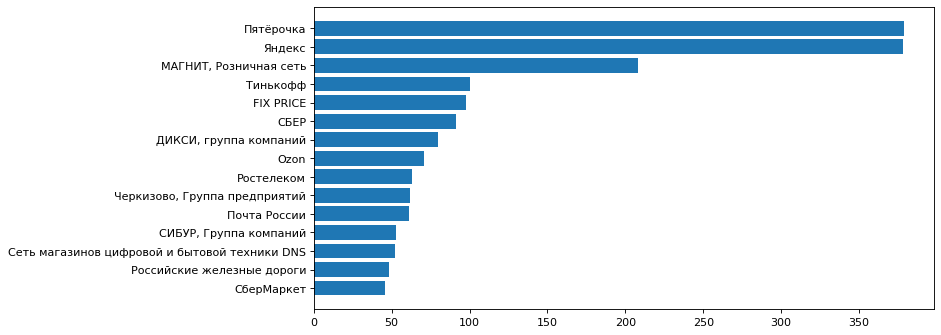

In [99]:
plt.figure(figsize=(10, 5), dpi=80)

data = Counter(text_df[text_df.branded_num_sym > 0]["employer.name"].values).most_common(15)
keys = [el[0] for el in data]
values = [el[1] for el in data]

plt.barh(keys[::-1], values[::-1])

In [70]:
len(text_df[text_df.branded_num_sym > 0]) / len(text_df)

0.18575977237314545

In [71]:
text_df[text_df.branded_num_sym > 0].branded_num_sym.mean()

1928.2368708971553

In [72]:
text_df[text_df.branded_num_sym > 0].num_branded_tokens.mean()

235.5162290299052

In [81]:
lemmas_counter = most_common_lemmas(text_df[text_df.branded_num_sym > 0].branded_lemmas.values)

In [82]:
lemmas_counter.most_common(15)

[('работа', 19687),
 ('опыт', 7732),
 ('компания', 6907),
 ('работать', 6418),
 ('наш', 5975),
 ('возможность', 5498),
 ('—', 5341),
 ('корпоративный', 4906),
 ('день', 4740),
 ('который', 4558),
 ('команда', 4386),
 ('свой', 4325),
 ('обучение', 4318),
 ('график', 4144),
 ('сотрудник', 4058)]

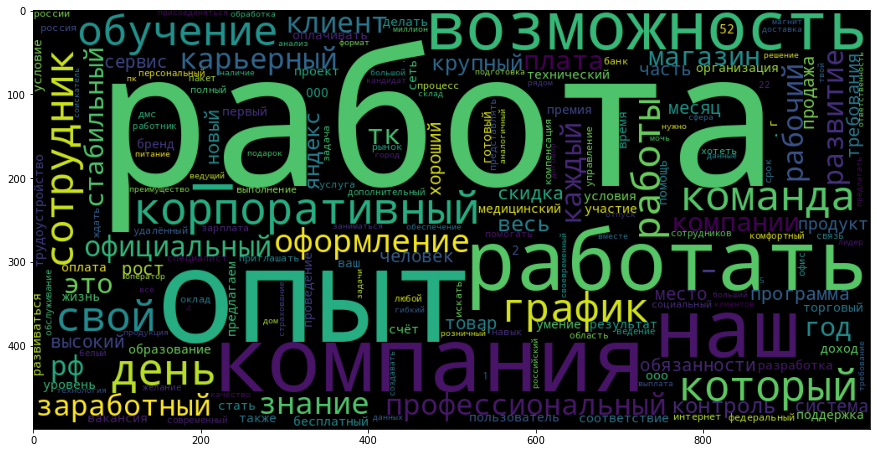

In [83]:
show_word_cloud(lemmas_counter)

### Basic description

In [84]:
len(text_df[text_df.num_sym > 0]) / len(text_df)

1.0

In [85]:
text_df[text_df.num_sym > 0].num_sym.mean()

1211.0659508163403

In [86]:
text_df[text_df.num_sym > 0].num_tokens.mean()

150.6776979879412

In [87]:
lemmas_counter = most_common_lemmas(text_df[text_df.num_sym > 0].lemmas.values)

In [88]:
lemmas_counter.most_common(15)

[('работа', 79132),
 ('опыт', 32437),
 ('обязанности', 19940),
 ('требования', 19454),
 ('график', 19085),
 ('условия', 18605),
 ('компания', 17342),
 ('знание', 16743),
 ('работать', 14430),
 ('контроль', 13962),
 ('оформление', 13946),
 ('наш', 13935),
 ('работы', 13838),
 ('заработный', 12724),
 ('рабочий', 12136)]

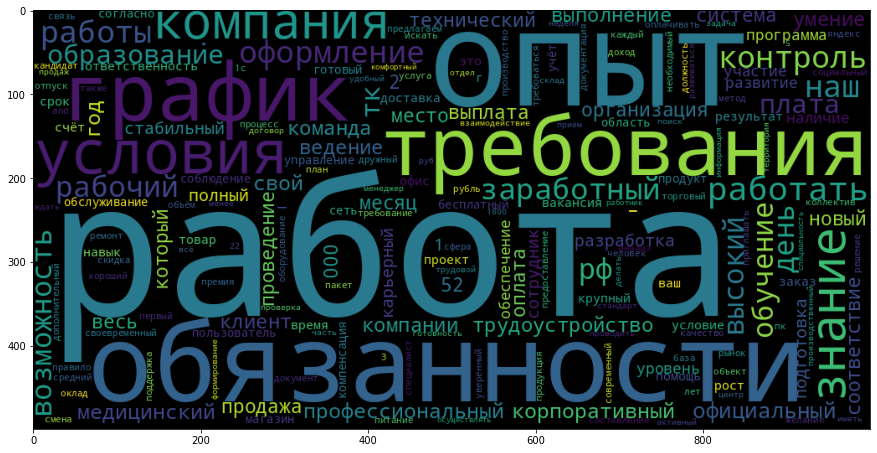

In [89]:
show_word_cloud(lemmas_counter)

### TD IDF анализ

In [90]:
def identity_tokenizer(text):
    return text

corpus = text_df.lemmas.values

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, min_df=0.05, lowercase=False)

response = tfidf.fit_transform(corpus)
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 15
top_n = feature_array[tfidf_sorting][:n]

In [91]:
top_n

array(['автомобиль', '000', 'российский', '—', 'часть', 'доставка',
       'крупный', 'наличие', 'день', 'работа', 'работать', 'знание',
       'вести', 'самостоятельно', 'обсуждаться'], dtype='<U18')

In [105]:
corpus = text_df.branded_lemmas.values

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, min_df=0.05, lowercase=False)

response = tfidf.fit_transform(corpus)
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 15
top_n = feature_array[tfidf_sorting][:n]

In [106]:
top_n

array(['—', 'клиент', 'образование', 'новый', 'наш', 'месяц', 'место',
       'крупный', 'который', 'корпоративный', 'компания', 'компании',
       'команда', 'карьерный', 'обязанности'], dtype='<U16')